In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pandas as pd
from PIL import Image
import torch
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Type, Union, List, Optional, Any
import copy
import tqdm

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
Path = 'DATABASE/'
train_path = 'DATABASE/Perfiles RESNET 2/Perfiles rotados/'
vft_path = 'DATABASE/Perfiles RESNET 2/vft values/vft_values.csv'

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, vft, transform=None):
        '''
        data : train data path
        vft : train vft path (csv file)
        '''
        self.train_data = data
        self.train_vft = pd.read_csv(vft)
        self.transform = transform
        
        self.profiles = self.train_vft.iloc[:, 0]
        self.velocities = self.train_vft.iloc[:, 1]

    def __len__(self):
        return len(self.train_vft)
    
    def __getitem__(self, index):
        profile = self.profiles[index]
        velocity = self.velocities[index]
        img = Image.open(os.path.join(self.train_data, profile))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return (img, velocity, profile)

In [13]:
transform = T.ToTensor()

In [14]:
full_dataset = CustomDataset(train_path,vft_path,transform)
BATCH_SIZE = 16
TRAIN_SIZE = int(len(full_dataset)*0.7)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE , VAL_SIZE)

66500 28500


In [15]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= True)

for i, (x,y,z) in enumerate(train_loader):
    print(i, x.shape , y.shape)
    if i==3: break

0 torch.Size([16, 1, 400, 400]) torch.Size([16])
1 torch.Size([16, 1, 400, 400]) torch.Size([16])
2 torch.Size([16, 1, 400, 400]) torch.Size([16])
3 torch.Size([16, 1, 400, 400]) torch.Size([16])


In [16]:
images, vft_values, names= next(iter(train_loader))
print(vft_values[1], names[1])

tensor(285., dtype=torch.float64) T24500_LG3p15_A51K15D04_He10Si766_46_18.jpg


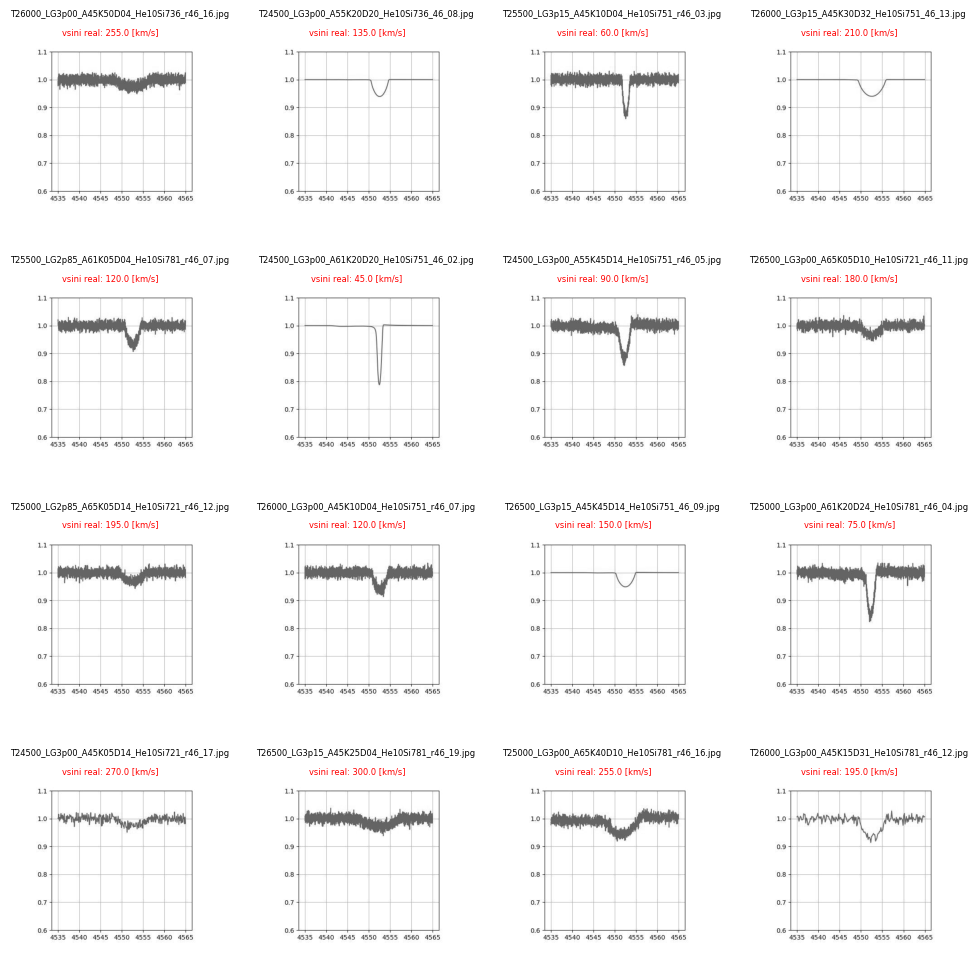

In [10]:
def visualize_batch(images, vft_values, names):
    batch_size = len(images)
    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index >= batch_size:
                break
            image = images[index].permute(1, 2, 0)
            image = image.clamp(0, 1)
            value = vft_values[index].item() 
            name = names[index] 
            axes[i][j].imshow(image, cmap='gray')
            axes[i][j].axis('off')
            axes[i][j].text(0.45, 0.98, f'vsini real: {value} [km/s]', color='red', transform=axes[i][j].transAxes, ha='center',fontsize=6)
            axes[i][j].text(0.5, 1.08, f'{name}', color='black', transform=axes[i][j].transAxes, ha='center',fontsize=6)
    plt.tight_layout()
    image_path = os.path.join("Imagenes", "Minibatch_r2.png")
    plt.savefig(image_path)
    plt.show()

images, vft_values, names = next(iter(train_loader))
visualize_batch(images, vft_values, names)

In [11]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Definir la arquitectura de ResNet con bloque Bottleneck
class ResNet(nn.Module):
    def __init__(self, block: Type[Bottleneck], layers: List[int], num_classes=1):
        super(ResNet, self).__init__()
        self.inplanes = 32
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=5, stride=2, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [15]:
from tqdm import tqdm
def accuracy(model, loader):
    total_loss = 0.0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for xi, yi, zi in loader:
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.float32)
            scores = model(xi)
            loss = torch.abs(scores - yi.unsqueeze(1)).sum()
            total_loss += loss.item()
            num_samples += xi.size(0)  
    mae_loss = total_loss / num_samples
    return mae_loss
         
def train(model, optimizer, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for i, (x, y, z) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.float32)
            optimizer.zero_grad()
            scores = model(x)
            loss = F.mse_loss(scores, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)
        val_loss = accuracy(model, val_loader)  # MAE conjunto de validación
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


In [16]:
lr = 0.0001
epochs = 30
resnet2 = ResNet(block=Bottleneck, layers=[5, 5, 5, 5], num_classes=1)
input_tensor = torch.randn(1, 1, 400, 400) 
output = resnet2(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1])


In [17]:
optimizer = torch.optim.Adam(resnet2.parameters(), lr)
train(resnet2, optimizer, epochs)

Epoch 1: 100%|██████████| 4157/4157 [23:41<00:00,  2.92batch/s]


Epoch 1 - Train Loss: 2104.5996 - Val Loss: 8.9057


Epoch 2: 100%|██████████| 4157/4157 [19:39<00:00,  3.52batch/s]


Epoch 2 - Train Loss: 115.4889 - Val Loss: 6.8435


Epoch 3: 100%|██████████| 4157/4157 [19:09<00:00,  3.62batch/s]


Epoch 3 - Train Loss: 94.1661 - Val Loss: 6.4687


Epoch 4: 100%|██████████| 4157/4157 [18:57<00:00,  3.66batch/s]


Epoch 4 - Train Loss: 84.0414 - Val Loss: 4.5686


Epoch 5: 100%|██████████| 4157/4157 [18:50<00:00,  3.68batch/s]


Epoch 5 - Train Loss: 74.1883 - Val Loss: 5.1810


Epoch 6: 100%|██████████| 4157/4157 [18:49<00:00,  3.68batch/s]


Epoch 6 - Train Loss: 69.7908 - Val Loss: 3.5727


Epoch 7: 100%|██████████| 4157/4157 [18:31<00:00,  3.74batch/s]


Epoch 7 - Train Loss: 64.7220 - Val Loss: 3.7050


Epoch 8: 100%|██████████| 4157/4157 [18:37<00:00,  3.72batch/s]


Epoch 8 - Train Loss: 57.2198 - Val Loss: 6.4967


Epoch 9: 100%|██████████| 4157/4157 [18:23<00:00,  3.77batch/s]


Epoch 9 - Train Loss: 56.6195 - Val Loss: 4.1874


Epoch 10: 100%|██████████| 4157/4157 [18:16<00:00,  3.79batch/s]


Epoch 10 - Train Loss: 52.0195 - Val Loss: 3.2723


Epoch 11: 100%|██████████| 4157/4157 [18:18<00:00,  3.78batch/s]


Epoch 11 - Train Loss: 46.5110 - Val Loss: 4.4395


Epoch 12: 100%|██████████| 4157/4157 [18:10<00:00,  3.81batch/s]


Epoch 12 - Train Loss: 46.0677 - Val Loss: 3.3173


Epoch 13: 100%|██████████| 4157/4157 [18:06<00:00,  3.82batch/s]


Epoch 13 - Train Loss: 38.1373 - Val Loss: 5.1467


Epoch 14: 100%|██████████| 4157/4157 [17:55<00:00,  3.87batch/s]


Epoch 14 - Train Loss: 35.1243 - Val Loss: 4.3997


Epoch 15: 100%|██████████| 4157/4157 [18:13<00:00,  3.80batch/s]


Epoch 15 - Train Loss: 34.1231 - Val Loss: 4.1294


Epoch 16: 100%|██████████| 4157/4157 [18:20<00:00,  3.78batch/s]


Epoch 16 - Train Loss: 33.8480 - Val Loss: 3.6443


Epoch 17: 100%|██████████| 4157/4157 [18:09<00:00,  3.81batch/s]


Epoch 17 - Train Loss: 27.8880 - Val Loss: 3.8474


Epoch 18: 100%|██████████| 4157/4157 [18:11<00:00,  3.81batch/s]


Epoch 18 - Train Loss: 30.1267 - Val Loss: 3.5092


Epoch 19: 100%|██████████| 4157/4157 [18:05<00:00,  3.83batch/s]


Epoch 19 - Train Loss: 27.8635 - Val Loss: 4.7518


Epoch 20: 100%|██████████| 4157/4157 [18:01<00:00,  3.84batch/s]


Epoch 20 - Train Loss: 26.6707 - Val Loss: 4.6580


Epoch 21: 100%|██████████| 4157/4157 [18:01<00:00,  3.85batch/s]


Epoch 21 - Train Loss: 26.3946 - Val Loss: 3.1520


Epoch 22: 100%|██████████| 4157/4157 [18:02<00:00,  3.84batch/s]


Epoch 22 - Train Loss: 23.3350 - Val Loss: 3.0333


Epoch 23: 100%|██████████| 4157/4157 [17:57<00:00,  3.86batch/s]


Epoch 23 - Train Loss: 24.5814 - Val Loss: 3.0596


Epoch 24: 100%|██████████| 4157/4157 [17:59<00:00,  3.85batch/s]


Epoch 24 - Train Loss: 23.6562 - Val Loss: 3.2507


Epoch 25: 100%|██████████| 4157/4157 [17:57<00:00,  3.86batch/s]


Epoch 25 - Train Loss: 22.1171 - Val Loss: 3.0289


Epoch 26: 100%|██████████| 4157/4157 [17:28<00:00,  3.97batch/s]


Epoch 26 - Train Loss: 21.8825 - Val Loss: 2.8887


Epoch 27: 100%|██████████| 4157/4157 [17:18<00:00,  4.00batch/s]


Epoch 27 - Train Loss: 22.7960 - Val Loss: 2.9605


Epoch 28: 100%|██████████| 4157/4157 [17:46<00:00,  3.90batch/s]


Epoch 28 - Train Loss: 19.9112 - Val Loss: 2.8059


Epoch 29: 100%|██████████| 4157/4157 [17:22<00:00,  3.99batch/s]


Epoch 29 - Train Loss: 19.0157 - Val Loss: 3.3249


Epoch 30: 100%|██████████| 4157/4157 [17:09<00:00,  4.04batch/s]


Epoch 30 - Train Loss: 19.3596 - Val Loss: 3.0443


In [18]:
def visualize_batch2(images, vft_values, values, names,image_path):
    batch_size = len(images)
    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index >= batch_size:
                break
            image = images[index,0]
            vft_value = vft_values[index].item()
            value = values[index] 
            name = names[index]
            axes[i][j].imshow(image, cmap='gray')
            axes[i][j].set_title(f'vsini: {vft_value} [km/s]', fontsize=6)  
            axes[i][j].axis('off')
            axes[i][j].text(0.45, 0.98, f'vsini real: {value} [km/s]', color='red', transform=axes[i][j].transAxes, ha='center',fontsize=6)
            axes[i][j].text(0.5, 1.15, f'{name}', color='black', transform=axes[i][j].transAxes, ha='center',fontsize=6)
    plt.tight_layout()
    plt.savefig(image_path)
    plt.show()

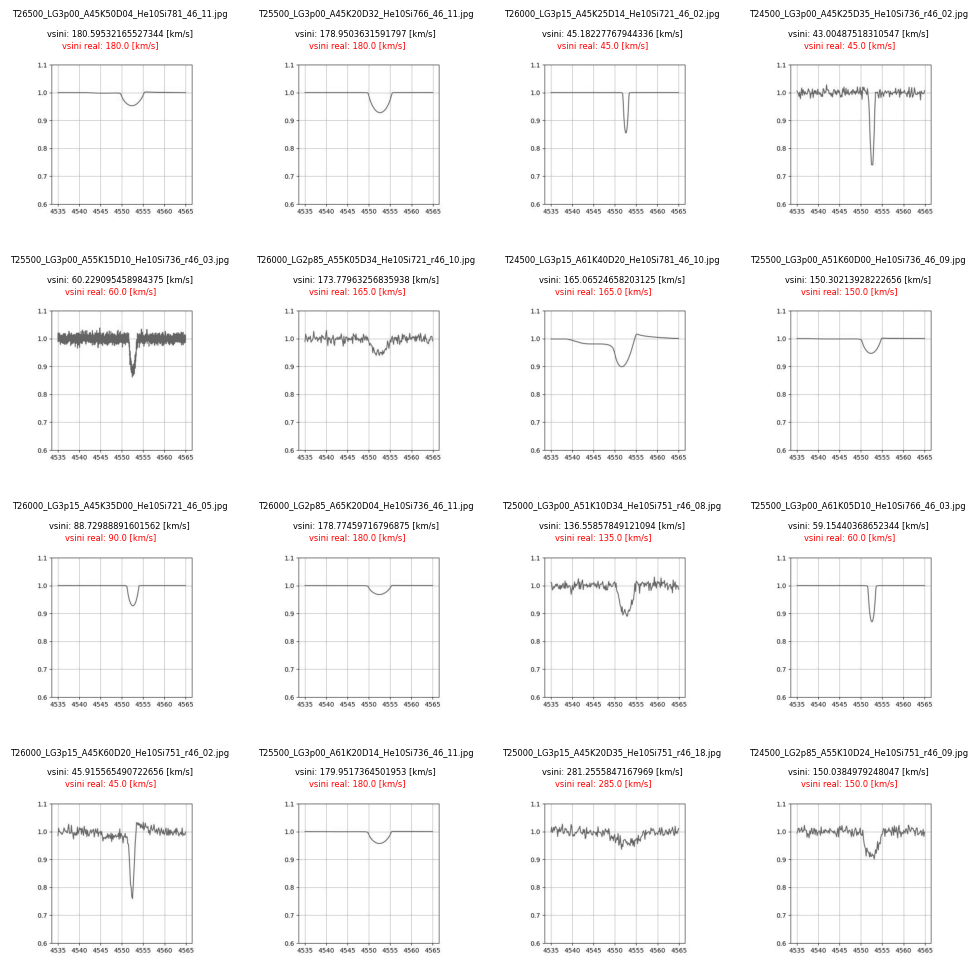

In [20]:
images_val, vft_values_val, names = next(iter(val_loader))
images_val = images_val.to(device, dtype=torch.float32)
resnet2 = resnet2.to(device)
with torch.no_grad():
    scores = resnet2(images_val)
images_val = images_val.cpu()
scores = scores.cpu()
values = [float(value.item()) for value in vft_values_val] 
image_path = os.path.join("Imagenes", "Minibatch_val_r2.png")
visualize_batch2(images_val, scores, values, names, image_path)

## Guardar modelo

In [22]:
model_path = 'Redes/resnet2.pth'

#torch.save(resnet2.state_dict(), model_path)

## Cargar modelo

In [9]:
resnet2 = ResNet(block=Bottleneck, layers=[4, 6, 8, 4], num_classes=1)
resnet2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [10]:
resnet2 = resnet2.to(device='cuda')
resnet2.eval()
transform = T.ToTensor()

In [11]:
ruta_carpeta = 'Modelos reales/Ajuste gaussiano/'
nombre_archivo = 'HD37042.jpg'
ruta_completa = os.path.join(ruta_carpeta, nombre_archivo)
imagen = transform(Image.open(ruta_completa))
imagen = imagen.to(device)
resnet1 = resnet2.to(device)
with torch.no_grad():
    scores = resnet2(imagen.unsqueeze(0)) 
imagen = imagen.cpu()
scores = scores.cpu()
scores.item()

-0.007114434614777565

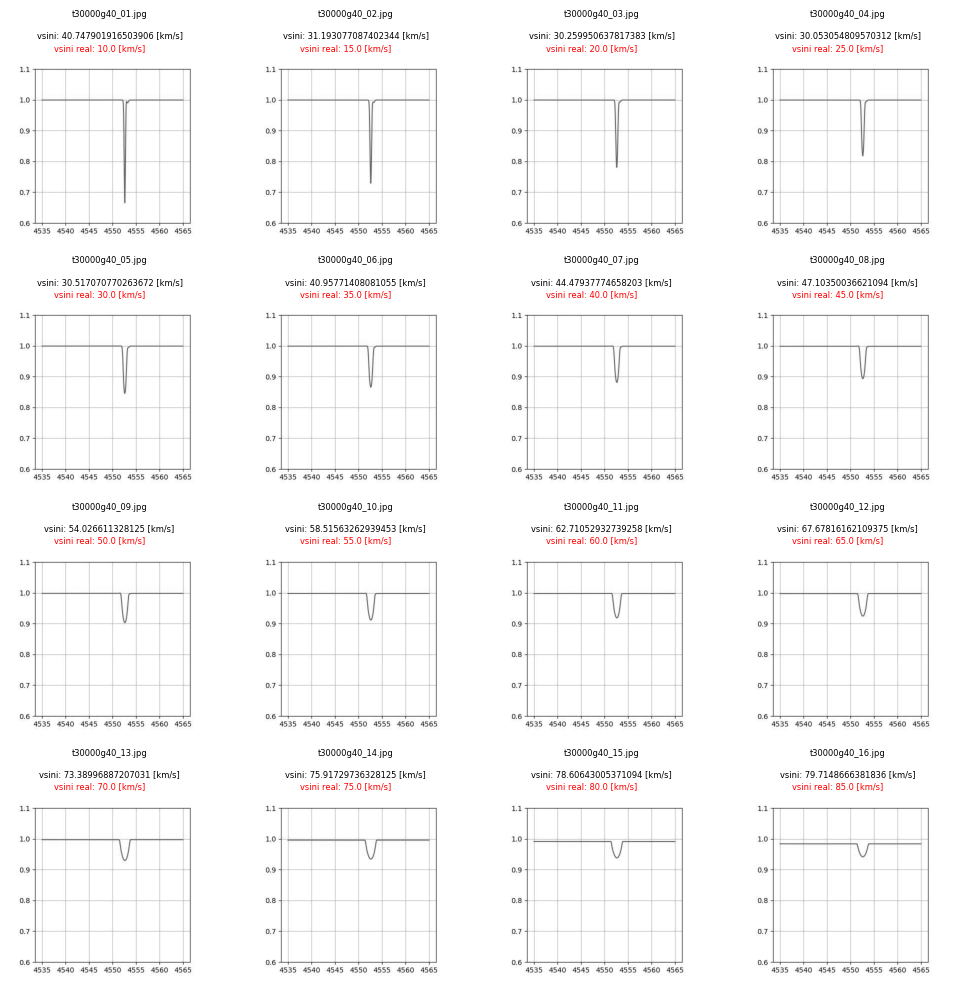

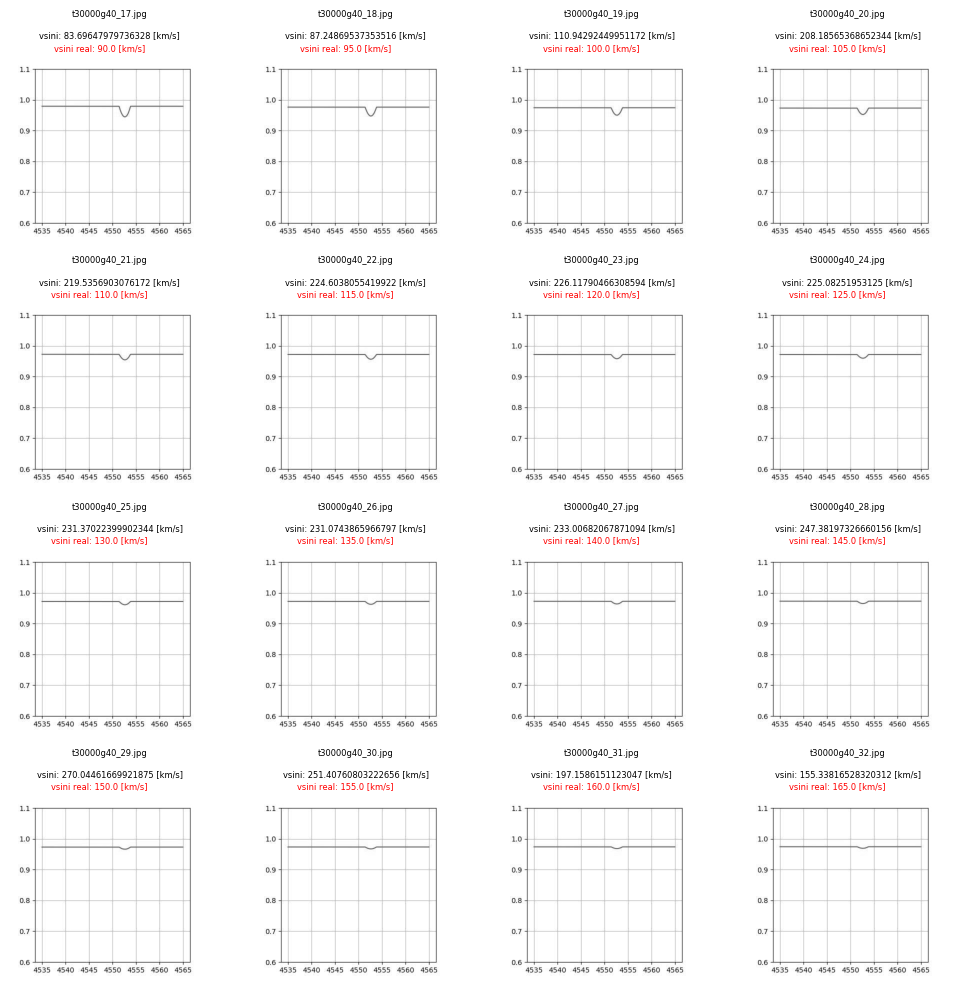

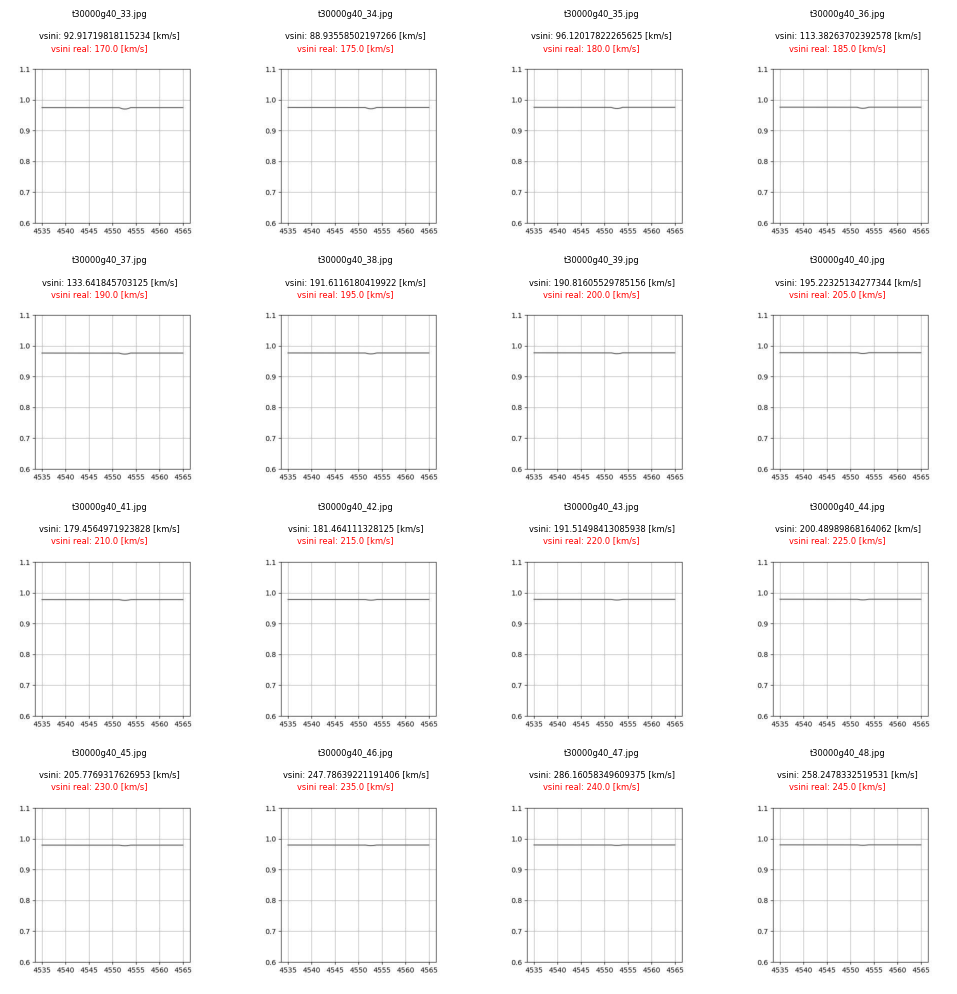

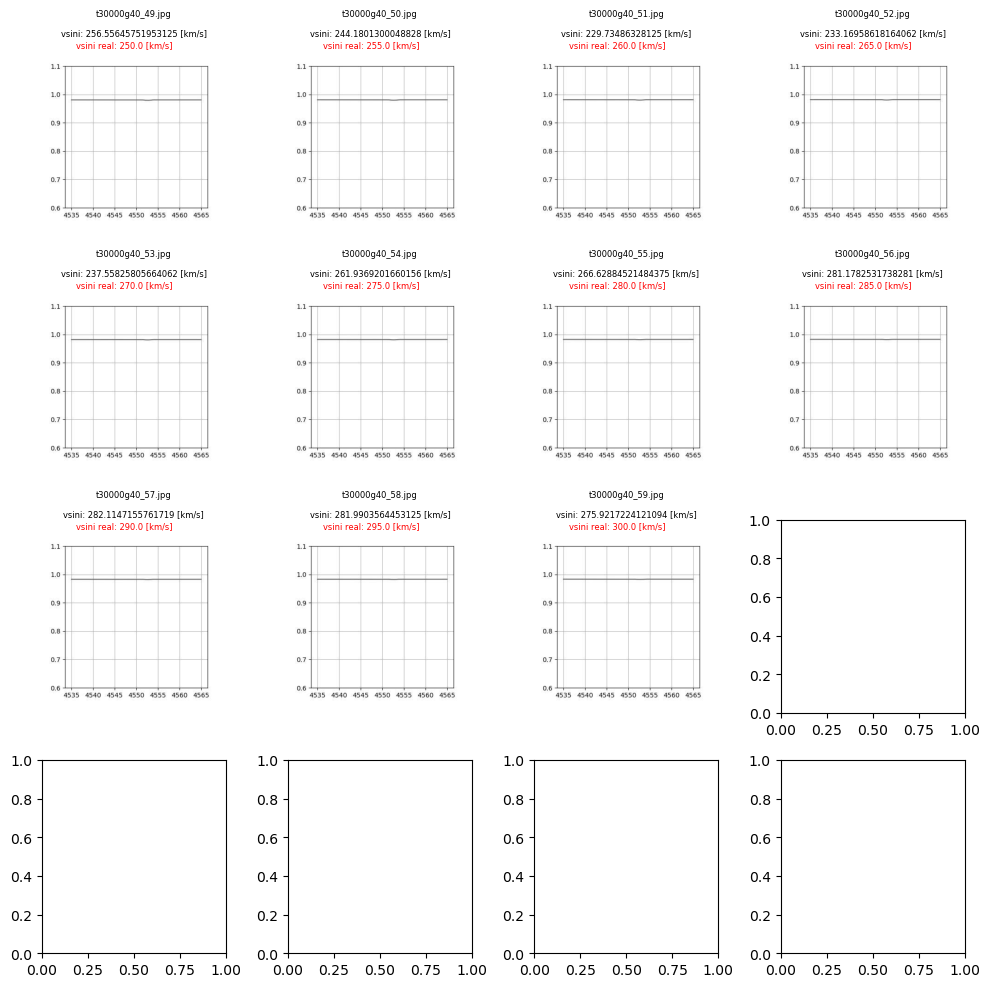

In [24]:
art_train_path = 'DATABASE/Articulo/red 2/Perfiles rotados/'
art_vft_path = 'DATABASE/Articulo/red 2/vft values/vft_values.csv'
new_dataset = CustomDataset(art_train_path, art_vft_path, transform)
new_val_loader = DataLoader(new_dataset, batch_size=59, shuffle=False)

batch_images, batch_vft_values, batch_names = next(iter(new_val_loader))
batch_images = batch_images.to(device, dtype=torch.float32)

resnet1 = resnet2.to(device)
with torch.no_grad():
    batch_scores = resnet2(batch_images)
batch_images = batch_images.cpu()
batch_scores = batch_scores.cpu()
batch_values = [float(value.item()) for value in batch_vft_values]

for i in range(0, 59, 16): 
    batch_subset_images = batch_images[i:i+16]
    batch_subset_scores = batch_scores[i:i+16]
    batch_subset_values = batch_values[i:i+16]
    batch_subset_names = batch_names[i:i+16]
    image_path = os.path.join("Imagenes/Articulo/2/", f"Minibatch_{i//16 + 1}_resnet2_2.png")
    visualize_batch2(batch_subset_images, batch_subset_scores, batch_subset_values, batch_subset_names, image_path)